In [1]:
import time
from typing import Iterable

import torch
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
from cgtasknet.tasks.reduce import ReduceTaskCognitive


class EveryTaskSubgroups:
    device = torch.device("cpu")

    def __init__(
        self, model: torch.nn.Module, tasks: Iterable[ReduceTaskCognitive]
    ) -> None:
        self._tasks = tasks
        self._model = model
        self._subgroups_finder = []

    def run(self, number_of_trials: int, dt: float = 1e-3):
        self._subgroups_finder = []
        number_of_trials = int(number_of_trials)
        dt = float(dt)
        print("*" * 20, "Start")
        for current_task in self._tasks:

            t0 = time.perf_counter()
            self._subgroups_finder.append(SubgroupFinder(dt))
            for i in range(number_of_trials):
                inputs, t_outputs, s, out = self._run_trial(current_task)
                self._subgroups_finder[-1].compute_average_freq(
                    [s.to(torch.device("cpu"))],
                    [inputs[:, 0, 0].to(torch.device("cpu"))],
                    [out.to(torch.device("cpu"))],
                    [t_outputs.to(torch.device("cpu"))],
                )
            print(
                f"Complete task: {current_task.task_number}, time: {time.perf_counter() - t0}s"
            )

    def _run_trial(self, task: ReduceTaskCognitive):
        inputs, t_outputs = task.dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(self.device)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float).to(self.device)
        out, _, s = self._model(inputs)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        return inputs, t_outputs, s, out

    def get_frequencies(self):
        fixation = []
        answer = []
        for subgoup_finder in self._subgroups_finder:
            t_fixation, t_answer = subgoup_finder.get_average_freq()
            fixation.append(t_fixation)
            answer.append(t_answer)
        return fixation, answer

In [2]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
)
import matplotlib.pyplot as plt
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

In [3]:
batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.1,
        positive_shift_delay_time=1.4,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.1, positive_shift_trial_time=0.8)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
sigma = 0.5
tasks = ["RomoTask1", "RomoTask2", "DMTask1", "DMTask2", "CtxDMTask1", "CtxDMTask2"]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
}
task_ctx1 = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    task_number=0,
)

task_ctx2 = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    task_number=1,
)

task_dm1 = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    task_number=2,
)

task_dm2 = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    task_number=3,
)

task_romo1 = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    task_number=4,
)

task_romo2 = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    task_number=5,
)
tasks_sequence = [task_ctx1, task_ctx2, task_dm1, task_dm2, task_romo1, task_romo2]

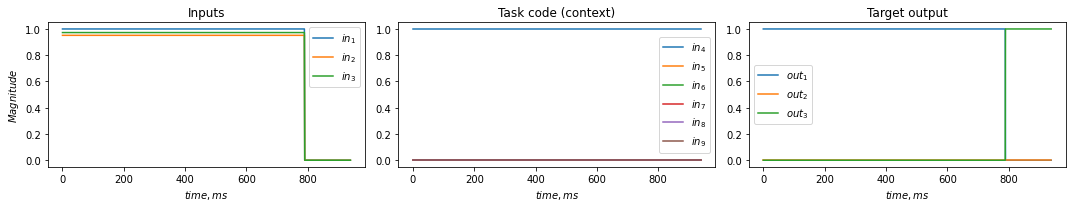

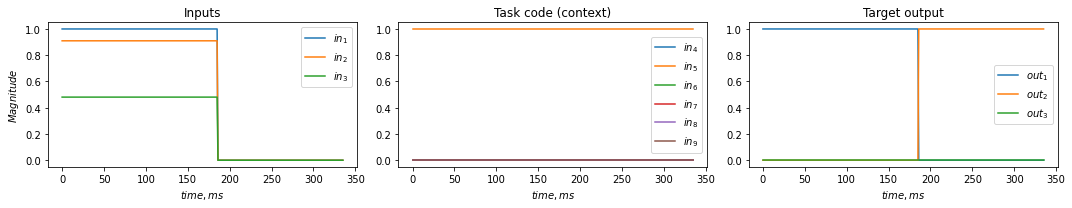

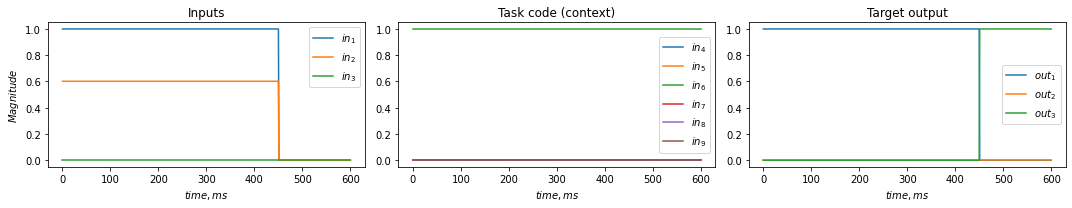

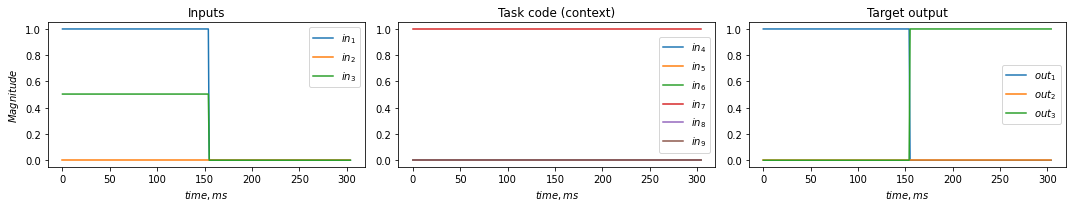

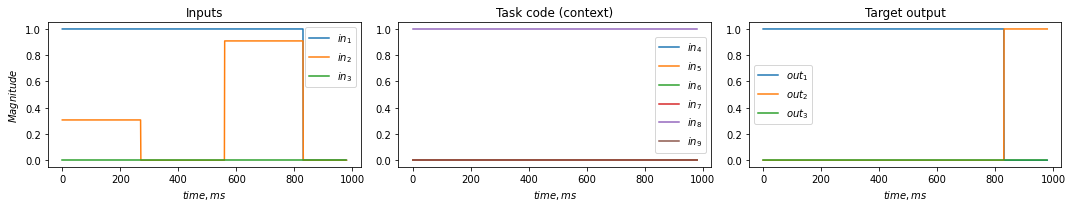

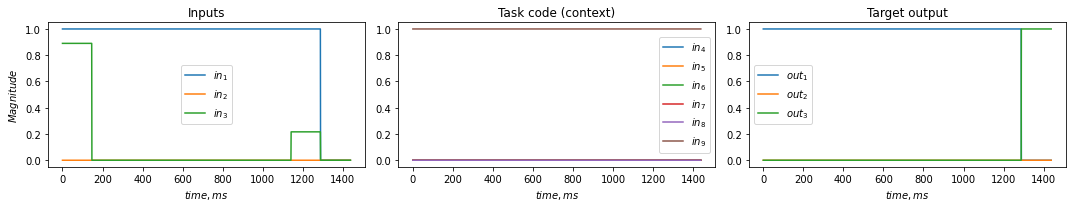

In [4]:
for task in tasks_sequence:
    inputs, t_outputs = task.dataset(n_trials=1)
    for bath in range(min(batch_size, 10)):
        fig = plt.figure(figsize=(15, 3))
        ax1 = fig.add_subplot(131)
        plt.title("Inputs")
        plt.xlabel("$time, ms$")
        plt.ylabel("$Magnitude$")
        for i in range(3):
            plt.plot(inputs[:, bath, i], label=rf"$in_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax2 = fig.add_subplot(132)
        plt.title("Task code (context)")
        plt.xlabel("$time, ms$")
        for i in range(3, inputs.shape[-1]):
            plt.plot(inputs[:, bath, i], label=rf"$in_{i + 1}$")
        plt.legend()
        plt.tight_layout()

        ax3 = fig.add_subplot(133)
        plt.title("Target output")
        plt.xlabel("$time, ms$")
        for i in range(t_outputs.shape[-1]):
            plt.plot(t_outputs[:, bath, i], label=rf"$out_{i + 1}$")
        plt.legend()
        plt.tight_layout()
    plt.show()
    plt.close()
    del inputs
    del t_outputs

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 450

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=0.5,
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        r"A:\src\multy_task\notebooks\train\reduce\lif_adex\romo_dm_ctx\Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_450"
    )
)

<All keys matched successfully>

In [6]:
subgroups = EveryTaskSubgroups(model, tasks_sequence)
subgroups.device = device
subgroups.run(100)
fixations, answers = subgroups.get_frequencies()

******************** Start
Complete task: 0, time: 62.219484s
Complete task: 1, time: 64.21953519999998s
Complete task: 2, time: 60.59238480000002s
Complete task: 3, time: 53.33401459999999s
Complete task: 4, time: 118.0379543s
Complete task: 5, time: 119.9844051s


In [62]:
import numpy as np


def plot_hist(data, c="#003153", alpha=1):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        plt.plot([x[i]] * 2, [0, data[i]], c=c, alpha=alpha, linewidth=0.5)

In [64]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach()).cpu()

In [65]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_by_fixation_out = [
    fixations[i] * out_weights[0, :] for i in range(len(fixations))
]
fixation_by_first_out = [
    fixations[i] * out_weights[1, :] for i in range(len(fixations))
]
answer_by_first_out = [answers[i] * out_weights[1, :] for i in range(len(answers))]

fixation_sort_by_first = [sort_elemnts_by_another(fixations[0], el) for el in fixations]

answer_sort_by_first = [sort_elemnts_by_another(answers[0], el) for el in answers]

fixation_sort_by_first_strength = [
    sort_elemnts_by_another(fixation_by_first_out[0], el) for el in fixations
]
answer_sort_by_first_strength = [
    sort_elemnts_by_another(fixation_by_first_out[0], el) for el in answers
]

fixation_strength_by_answer_strength_sort = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in fixation_by_first_out
]

answer_strength_by_answer_strength_sort = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in answer_by_first_out
]

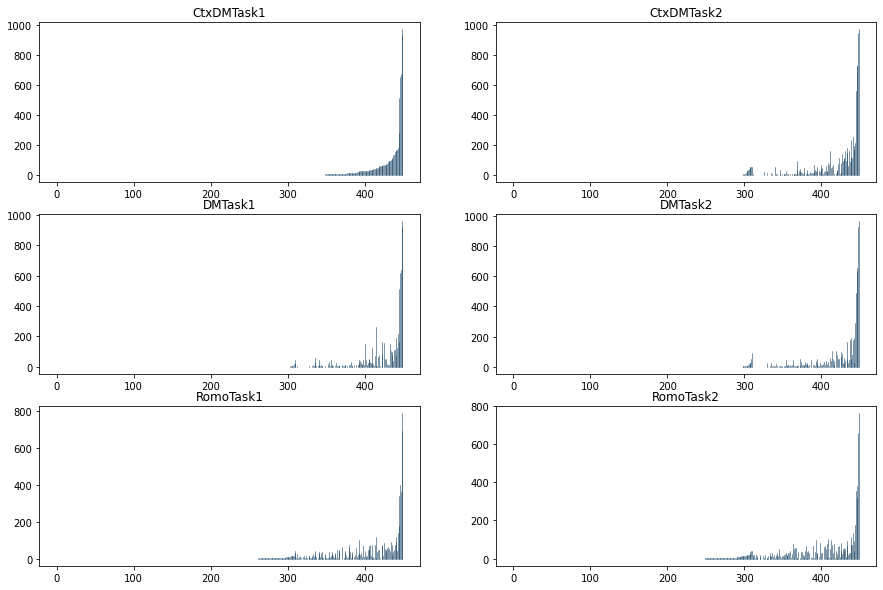

In [66]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_sort_by_first)):
    plt.subplot(320 + i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(fixation_sort_by_first[i])
plt.show()
plt.close()

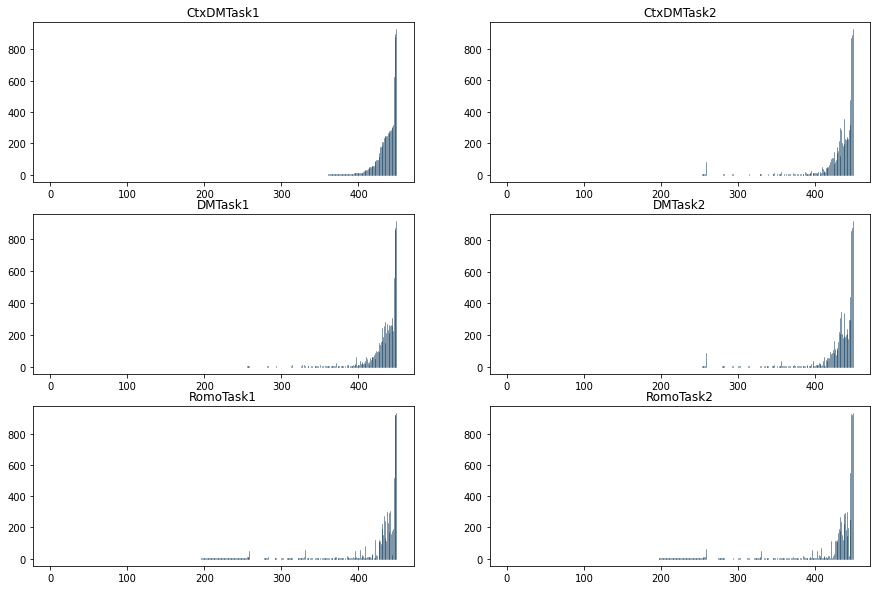

In [67]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_first)):
    plt.subplot(320 + i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_first[i])
plt.show()
plt.close()

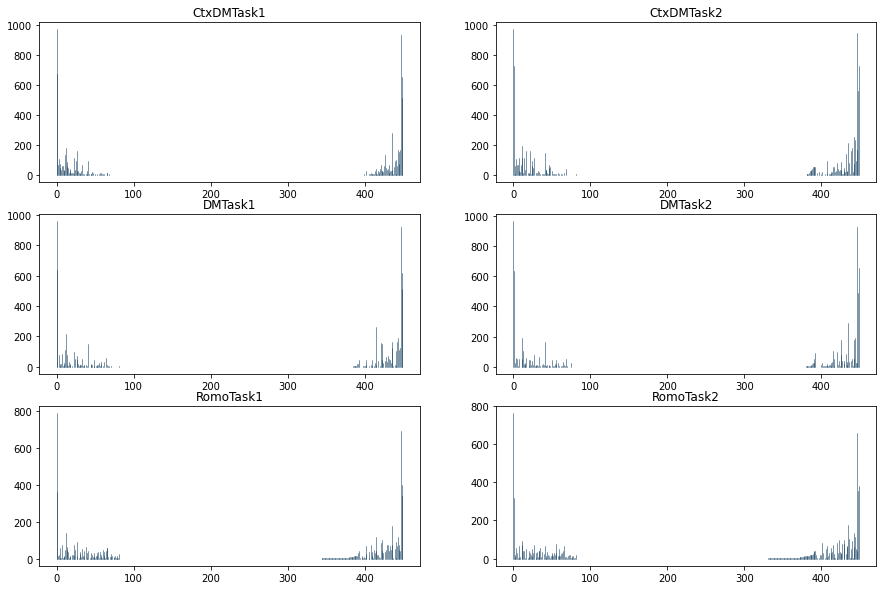

In [68]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_sort_by_first_strength)):
    plt.subplot(320 + i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(fixation_sort_by_first_strength[i])
plt.show()
plt.close()

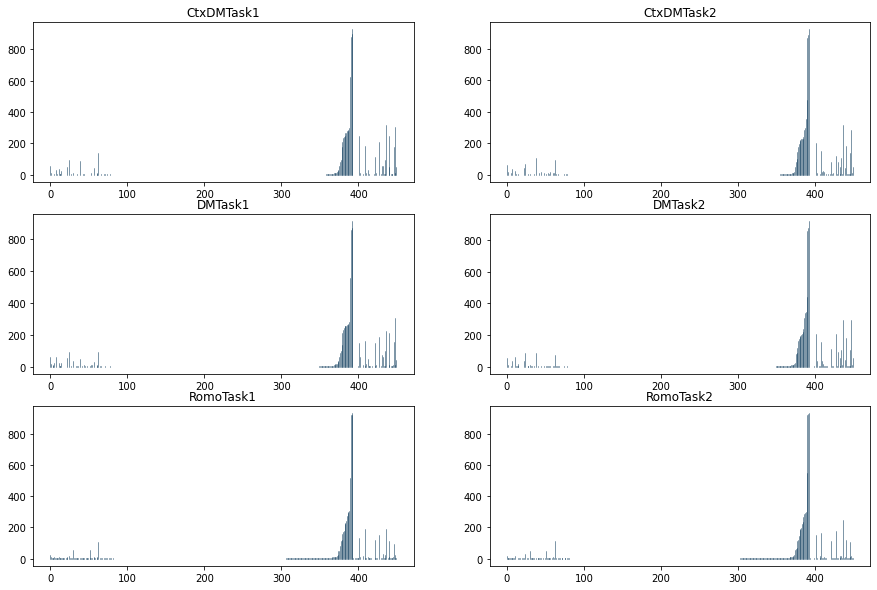

In [69]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_first_strength)):
    plt.subplot(320 + i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_first_strength[i])
plt.show()
plt.close()

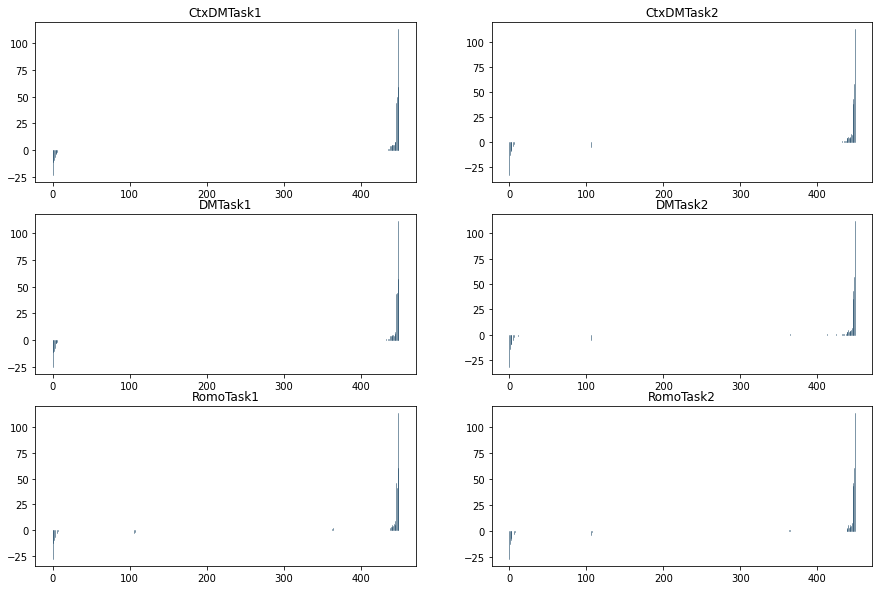

In [70]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_strength_by_answer_strength_sort)):
    plt.subplot(320 + i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_strength_by_answer_strength_sort[i])
plt.show()
plt.close()

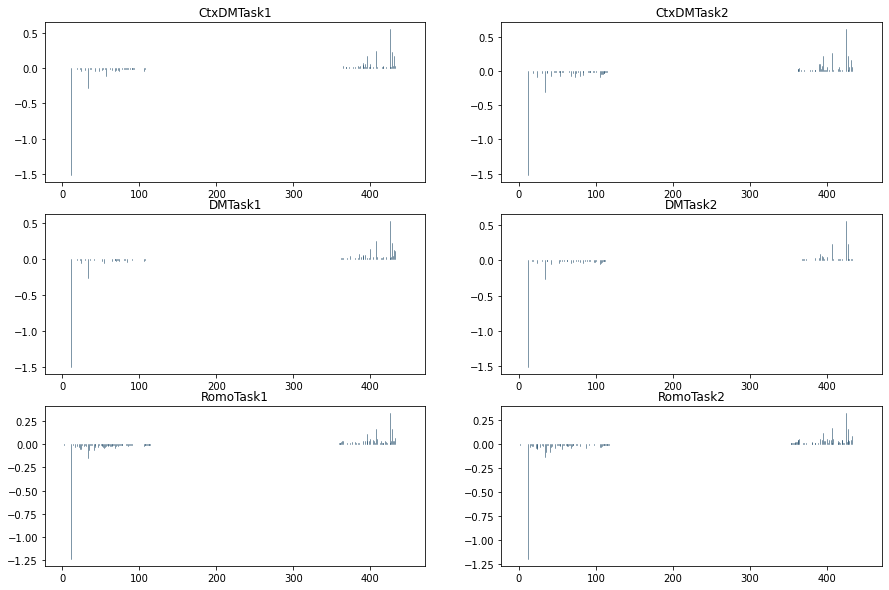

In [71]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_strength_by_answer_strength_sort)):
    plt.subplot(320 + i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(fixation_strength_by_answer_strength_sort[i])
plt.show()
plt.close()